<a href="https://colab.research.google.com/github/Bambillo1/ComputerVision/blob/main/multiple_car_object_detection.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Objective

The objective of this notebook is to perform object detection on images with a focus on identifying cars. To accomplish this, we will be using multiple object detection techniques to predict the precise coordinates of the bounding boxes around the cars in the image.

# General Procedure

To achieve our goal, we must first preprocess the data to ensure it is in a suitable format. Next, we will employ a hyperparameter tuner to search for optimal parameters for our specific task. Finally, we will utilize these optimized hyperparameters to train and save our model.

# Imports

In [ ]:
# Data Manipulation
import numpy as np
import pandas as pd

# Visualization/Image Processing
import cv2
import matplotlib.pyplot as plt

# Machine Learning
import tensorflow as tf
from tensorflow.keras.layers import Conv2D, Input, BatchNormalization, Flatten, MaxPool2D, Dense
!pip install keras_tuner
import keras_tuner as kt
from sklearn.model_selection import train_test_split

# Other
from pathlib import Path
import os
import math

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
!gdown --id 16GIiyUGiMO9jOxjOWhlQd4P3F30_QrtB

/usr/local/lib/python3.10/dist-packages/gdown/cli.py:121: FutureWarning: Option `--id` was deprecated in version 4.3.1 and will be removed in 5.0. You don't need to pass it anymore to use a file ID.
  warnings.warn(
Downloading...
From: https://drive.google.com/uc?id=16GIiyUGiMO9jOxjOWhlQd4P3F30_QrtB
To: /content/car_detection.zip
100% 118M/118M [00:00<00:00, 125MB/s]


In [ ]:
from zipfile import ZipFile
filename = 'car_detection.zip'
with ZipFile(filename, 'r') as zip:
  zip.extractall()
  print('All Extracted')

All Extracted


# Load the Data

In [ ]:
train_images_path = Path("./car-object-detection/data/training_images")
test_images_path = Path("./car-object-detection/data/testing_images")

# Preprocessing Data

Our dataset is presented in csv format, with a single column for the image name and four columns for the bounding box coordinates. However, a challenge we encounter is that a single image may contain multiple cars, and the coordinates for each car may be listed in separate rows. To address this, we must group the coordinates by image name. Additionally, to ensure consistency across all rows, we pad the rows without the maximum number of coordinates with zeros and flatten them to a single array per row.


Reading Data: Loads a CSV file (train_solution_bounding_boxes.csv) assumed to contain bounding box coordinates for object detection.
Data Manipulation:
Converts the columns for bounding box coordinates to integers (xmin, ymin, xmax, ymax).
Groups the data by image and combines the coordinates into lists under the 'coordinates' column for each image.
Renames columns to 'image_name' and 'coordinates' for clarity.
Padding: Finds the maximum length of coordinates across all images and pads the coordinate lists with zeros to make them uniform in length.
This code seems to be preparing bounding box coordinates for object detection tasks, ensuring consistent formatting for the bounding box data associated with each image. Adjustments might be needed depending on the specific structure and content of your dataset.

In [ ]:
# Read the CSV file containing bounding box coordinates for object detection
train = pd.read_csv("./car-object-detection/data/train_solution_bounding_boxes (1).csv")

# Convert coordinate columns to integers (assuming they contain coordinate information)
train[['xmin', 'ymin', 'xmax', 'ymax']] = train[['xmin', 'ymin', 'xmax', 'ymax']].astype(int)

# Group by image and concatenate coordinates into lists
train = train.groupby('image')[['xmin', 'ymin', 'xmax', 'ymax']].apply(lambda x: x.values.flatten().tolist()).reset_index()

# Rename columns for better readability
train.columns = ['image_name', 'coordinates']

# Find the maximum length of coordinates to ensure uniformity
max_length = train['coordinates'].str.len().max()

# Pad coordinates lists with zeros to match the maximum length
train['coordinates'] = train['coordinates'].apply(lambda x: x + [0] * (max_length - len(x)))





Empty List Initialization: Initializes an empty list named test_images to store the test images.
Iterating through Files: Loops through the files in the test_images_path directory.
Image Processing:
Constructs the full path of each image file using os.path.join.
Reads each image using OpenCV (cv2.imread).
Normalizes pixel values by dividing by 255 to scale them between 0 and 1.
Appending Images: Adds each normalized image to the test_images list.
This code snippet reads and processes images from a directory specified by test_images_path, storing the normalized images in the test_images list for further use, such as prediction or evaluation. Adjust the path and image processing steps as needed based on your requirements.

In [ ]:
test_images = []  # Initialize an empty list to store test images

# Iterate through filenames in the test images directory
for filename in os.listdir(test_images_path):
    img_path = os.path.join(test_images_path, filename)  # Get the full path of the image
    image = cv2.imread(img_path) / 255.  # Read the image using OpenCV and normalize pixel values
    test_images.append(image)  # Append the normalized image to the list


# Display

We create some functions for displaying

This function, display_image, visualizes images with bounding boxes. It takes in an image (img), optionally normalized, and lists of bounding box coordinates (bbox_coords and pred_coords). It draws green rectangles for the bbox_coords (ground truth) and red rectangles for pred_coords (predicted coordinates).

These two functions provide ways to display images with bounding boxes from file paths or from a DataFrame. display_image_from_file reads an image from a file path (path/name) and displays it with bounding box coordinates provided as bbox_coords. display_from_dataframe takes a row from a DataFrame (assuming a column named 'image_name' for file names and 'coordinates' for bounding box coordinates) and displays the image.


The display_grid function creates a grid layout to display a specified number of random images from a DataFrame (df). It plots a 1x3 grid by default (n_items=3), showing random images with bounding box coordinates obtained from the DataFrame using display_from_dataframe. Adjust the number of items and DataFrame as needed.

In [ ]:

#def display_image(img, bbox_coords=[], confidence_scores=[], norm=False):
def display_image(img, bbox_coords=[], pred_coords=[], norm=False):
    # if the image has been normalized, scale it up
    if norm:
        img *= 255.
        img = img.astype(np.uint8)

    # Draw the bounding boxes
    while len(bbox_coords) > 0:
        xmin, ymin, xmax, ymax = bbox_coords[:4]
        bbox_coords = bbox_coords[4:]
        img = cv2.rectangle(img, (int(xmin), int(ymin)), (int(xmax), int(ymax)), (0, 255, 0), 3)

    while len(pred_coords) > 0:
        xmin, ymin, xmax, ymax = pred_coords[:4]
        pred_coords = pred_coords[4:]
        img = cv2.rectangle(img, (int(xmin), int(ymin)), (int(xmax), int(ymax)), (255, 0, 0), 3)


    plt.imshow(img)
    plt.xticks([])
    plt.yticks([])

'''
def display_image(img, bbox_coords=[], pred_coords=[], norm=False):

    # Draw the bounding boxes
    while len(bbox_coords) > 0:
        xmin, ymin, xmax, ymax = bbox_coords[:4]
        bbox_coords = bbox_coords[4:]
        img = cv2.rectangle(img, (int(xmin), int(ymin)), (int(xmax), int(ymax)), (0, 255, 0), 3)

    while len(pred_coords) > 0:
        xmin, ymin, xmax, ymax = pred_coords[:4]
        pred_coords = pred_coords[4:]
        img = cv2.rectangle(img, (int(xmin), int(ymin)), (int(xmax), int(ymax)), (255, 0, 0), 3)

        plt.imshow(img)
        plt.xticks([])
        plt.yticks([])
'''
# Rest of the code remains the same

def display_image_from_file(name, bbox_coords=[], path=train_images_path):
    img = cv2.imread(str(path/name))
    display_image(img, bbox_coords=bbox_coords)

def display_from_dataframe(row, path=train_images_path):
    display_image_from_file(row['image_name'], bbox_coords=row.coordinates, path=path)

def display_grid(df=train, n_items=3):
    plt.figure(figsize=(20, 10))

    # get 3 random entries and plot them in a 1x3 grid
    rand_indices = [np.random.randint(0, df.shape[0]) for _ in range(n_items)]

    for pos, index in enumerate(rand_indices):
        plt.subplot(1, n_items, pos + 1)
        display_from_dataframe(df.loc[index, :])





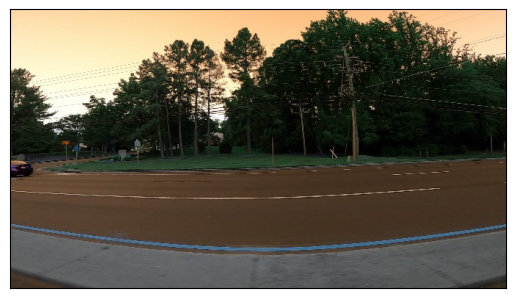

In [ ]:
display_image_from_file("vid_4_10520.jpg")

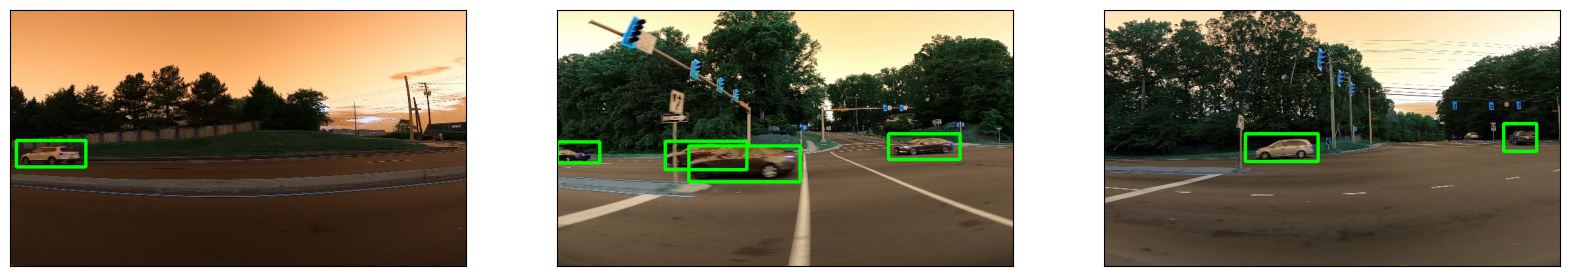

In [ ]:
display_grid()

The functions work perfectly, and the logic for the bounding boxes seems to be flawless. We can now move on to creating and training the model.

# Model Training

To prepare the data for the model, we create a data generator that returns both the image and the coordinates associated with a particular image name.

Function Purpose:
This is a data generator function that creates batches of images and their corresponding bounding box coordinates.
Initialization:
Initializes arrays (images and bounding_box_coords) to hold images and bounding box coordinates for a batch.
Batch Creation:
In a loop (for i in range(batch_size)), it randomly selects rows from the DataFrame (df) and reads the corresponding images from the file path (path/row.image_name).
Normalizes the images by dividing pixel values by 255 and stores them in the images array.
Retrieves the bounding box coordinates from the DataFrame (row.coordinates) and stores them in the bounding_box_coords array.
Yielding:
Yields a batch of images ('image') and their corresponding bounding box coordinates ('coords') as dictionaries.

In [ ]:
def data_generator(df=train, batch_size=16, path=train_images_path):
    while True:
        # Initialize arrays to hold images and bounding box coordinates
        images = np.zeros((batch_size, 380, 676, 3))  # Array to store images
        bounding_box_coords = np.zeros((batch_size, max_length))  # Array for bounding box coordinates

        # Iterate to fill the arrays for the batch
        for i in range(batch_size):
            # Randomly select an index from the DataFrame
            rand_index = np.random.randint(0, train.shape[0])
            row = df.loc[rand_index, :]  # Get the DataFrame row for the selected index

            # Read and normalize the image, store in the images array
            images[i] = cv2.imread(str(path/row.image_name)) / 255.

            # Store the bounding box coordinates in the bounding_box_coords array
            bounding_box_coords[i] = np.array(row.coordinates)

        # Yield the batch of images and corresponding bounding box coordinates
        yield {'image': images}, {'coords': bounding_box_coords}


The dictionary keys are crucial, as keras needs them to locate the correct input/output.

'\nimport random\n\n# Test the generator to obtain a single batch of data\nexample, label = next(data_generator(batch_size=1))  # Fetches a single batch using the data generator\nimg = example[\'image\'][0]  # Extracts the image from the batch\nbbox_coords = label[\'coords\'][0]  # Extracts bounding box coordinates from the batch\n\n# Generate random confidence scores for each bounding box\nconfidence_scores = [random.uniform(0.5, 1.0) for _ in range(len(bbox_coords) // 4)]\n\n# Display the image with bounding box coordinates using the previously defined display_image function\ndisplay_image(img, bbox_coords=bbox_coords, confidence_scores = confidence_scores, norm=True)\n\nimport random\n\n# Test the generator to obtain a single batch of data\nexample, label = next(data_generator(batch_size=1))  # Fetches a single batch using the data generator\nimg = example[\'image\'][0]  # Extracts the image from the batch\nbbox_coords = label[\'coords\'][0]  # Extracts bounding box coordinates from

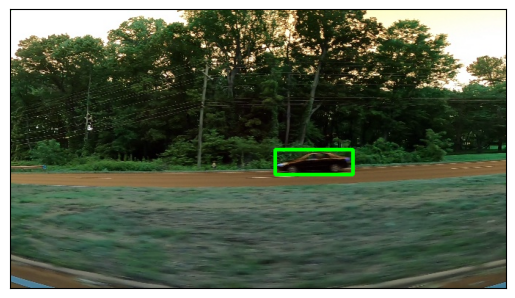

In [ ]:
example, label = next(data_generator(batch_size=1))  # Fetches a single batch using the data generator
img = example['image'][0]  # Extracts the image from the batch
bbox_coords = label['coords'][0]  # Extracts bounding box coordinates from the batch

# Display the image with bounding box coordinates using the previously defined display_image function
display_image(img, bbox_coords=bbox_coords,  norm=True)


# Model Building

We create a model builder and specify the hyperparameters we wish to experiment with. Since we are working with images, we typically construct the model by layering a combination of convolutional and pooling layers until a suitable architecture is achieved, followed by a flattenera and one or more dense layers to process the input. At last you cuold also specify other hyperparameters to experiment with like the loss, the number and wideness of the dense layers or the learning rate.

In [ ]:
def model_builder(hp):
    # Initialize the sequential model
    model = tf.keras.Sequential()
    model.add(Input(shape=[380, 676, 3], name='image'))
    # Define the number of convolutional layers and the starting filter size
    hp_convolutional_layers = hp.Int('convolutional_layers', min_value=6, max_value=12, step=2)
    hp_power_filter = hp.Int('first_power_filter', min_value=3, max_value=5, step=1)
    for i in range(hp_convolutional_layers):
        # Add convolutional, normalization, and pooling layers
        model.add(Conv2D(2**hp_power_filter, 3, activation='relu', padding='same'))
        model.add(BatchNormalization())
        model.add(MaxPool2D(2, padding='same'))
        hp_power_filter = min(10, hp_power_filter + 1)

    # Add flattening and dense layers for processing
    model.add(Flatten())
    model.add(Dense(256, activation='relu'))
    model.add(Dense(32, activation='relu'))
    model.add(Dense(max_length, activation='relu', name='coords'))

    # Compile the model
    model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=1e-2),
                  loss='mse',
                  metrics=['accuracy'])

    return model


We make some functions in order to test the model more visually

In [ ]:
def test_model(model, datagen):
    # Obtain an example and its label from the data generator
    example, label = next(datagen)

    # Extract image and coordinates from the example and label
    X = example['image']
    y = label['coords']

    # Predict the bounding box coordinates using the model
    pred_bbox = model.predict(X)[0]

    # Extract the image and ground truth coordinates
    img = X[0]
    gt_coords = y[0]

    # Display the image with ground truth and predicted coordinates
    display_image(img, bbox_coords=gt_coords, pred_coords=pred_bbox, norm=True)

def test(model):
    # Generate data using a data generator
    datagen = data_generator(batch_size=1)

    # Create a plot to display test images and their predictions
    plt.figure(figsize=(15,7))
    for i in range(5):
        plt.subplot(1, 5, i + 1)
        test_model(model, datagen)
    plt.show()

class ShowTestImages(tf.keras.callbacks.Callback):
    def on_epoch_end(self, epoch, logs=None):
        # Call the test function to display images at the end of each epoch
        test(self.model)


We utilize Keras Tuner to search for the hyperparameters specified beforehand, and implement early stopping to increase the efficiency of the process.

In [ ]:
early_stopping = tf.keras.callbacks.EarlyStopping(monitor='loss', patience=3)

# instantiate the tuner and perform hypertuning
tuner = kt.Hyperband(model_builder,
                     objective='accuracy',
                     max_epochs=5,
                     factor=3)
with tf.device('/GPU:0'):
    tuner.search(data_generator(), epochs=5, steps_per_epoch = 500, callbacks=[early_stopping,ShowTestImages()])


# Get the optimal hyperparameters
best_hps = tuner.get_best_hyperparameters(num_trials=1)[0]

print(f'Number of convolutional layers: {best_hps.get("convolutional_layers")}')
print(f'Filters in the first covolutional layer: {2**best_hps.get("first_power_filter")}')

Trial 10 Complete [00h 13m 27s]
accuracy: 0.7540000081062317

Best accuracy So Far: 0.9474999904632568
Total elapsed time: 01h 12m 59s
Number of convolutional layers: 10
Filters in the first covolutional layer: 8


We build the model using the best hyperparamenters found

In [ ]:
# build the best model using the optimal hyperparameters
model = tuner.hypermodel.build(best_hps)

model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_12 (Conv2D)          (None, 380, 676, 8)       224       
                                                                 
 batch_normalization_12 (Ba  (None, 380, 676, 8)       32        
 tchNormalization)                                               
                                                                 
 max_pooling2d_12 (MaxPooli  (None, 190, 338, 8)       0         
 ng2D)                                                           
                                                                 
 conv2d_13 (Conv2D)          (None, 190, 338, 16)      1168      
                                                                 
 batch_normalization_13 (Ba  (None, 190, 338, 16)      64        
 tchNormalization)                                               
                                                      

We train the model we just created

Epoch 1/15
1/1 [==============================] - 0s 34ms/step


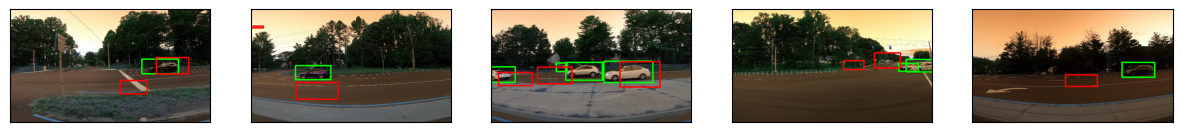

500/500 [==============================] - 134s 252ms/step - loss: 6266.5898 - accuracy: 0.6801
Epoch 2/15
1/1 [==============================] - 0s 61ms/step


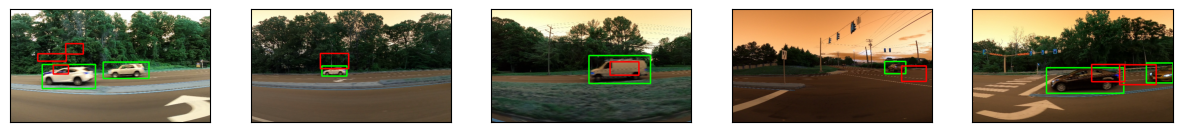

500/500 [==============================] - 129s 258ms/step - loss: 2827.1323 - accuracy: 0.8407
Epoch 3/15
1/1 [==============================] - 0s 108ms/step


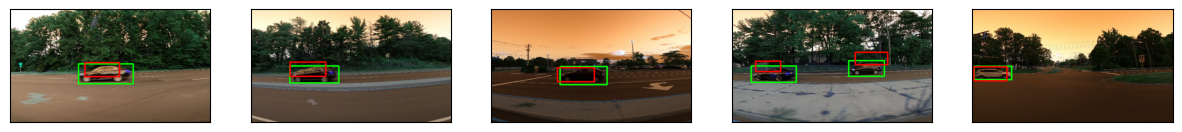

500/500 [==============================] - 128s 256ms/step - loss: 1350.0256 - accuracy: 0.9046
Epoch 4/15
1/1 [==============================] - 0s 76ms/step


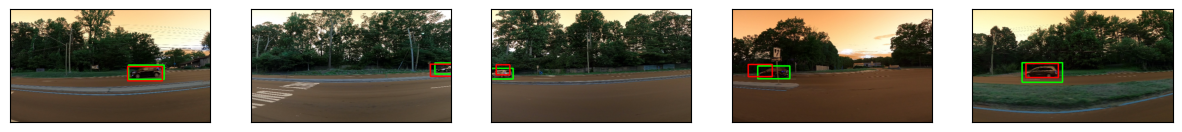

500/500 [==============================] - 129s 258ms/step - loss: 1453.7330 - accuracy: 0.9034
Epoch 5/15
1/1 [==============================] - 0s 54ms/step


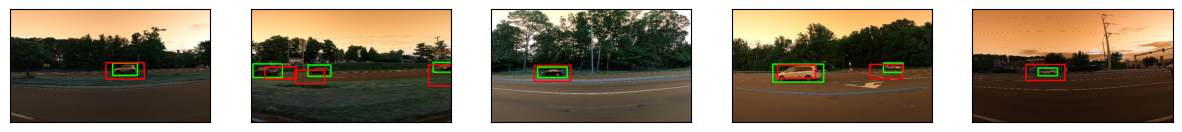

500/500 [==============================] - 128s 257ms/step - loss: 818.3419 - accuracy: 0.9381
Epoch 6/15
1/1 [==============================] - 0s 35ms/step


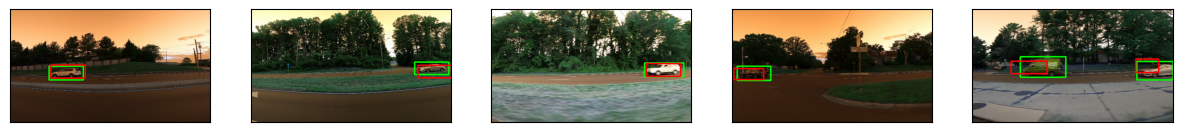

500/500 [==============================] - 137s 274ms/step - loss: 1156.2140 - accuracy: 0.9183
Epoch 7/15
1/1 [==============================] - 0s 39ms/step


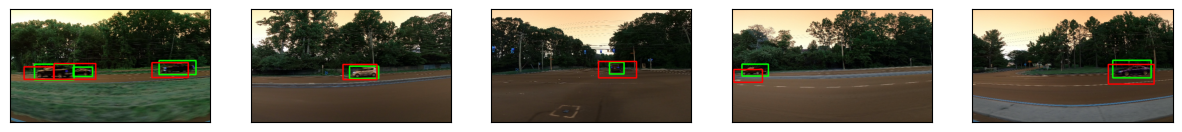

500/500 [==============================] - 128s 256ms/step - loss: 785.3548 - accuracy: 0.9380
Epoch 8/15
1/1 [==============================] - 0s 36ms/step


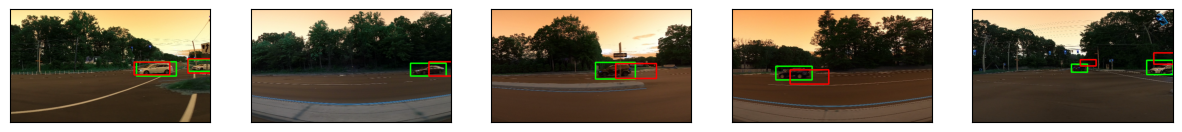

500/500 [==============================] - 127s 255ms/step - loss: 644.3295 - accuracy: 0.9488
Epoch 9/15
1/1 [==============================] - 0s 91ms/step


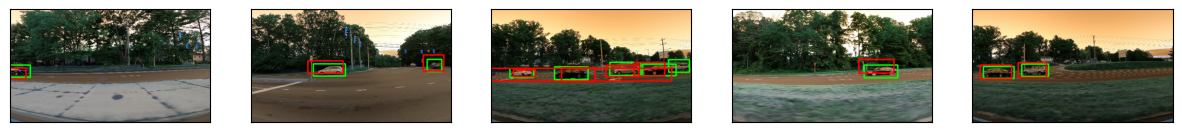

500/500 [==============================] - 130s 260ms/step - loss: 756.3817 - accuracy: 0.9425
Epoch 10/15
1/1 [==============================] - 0s 121ms/step


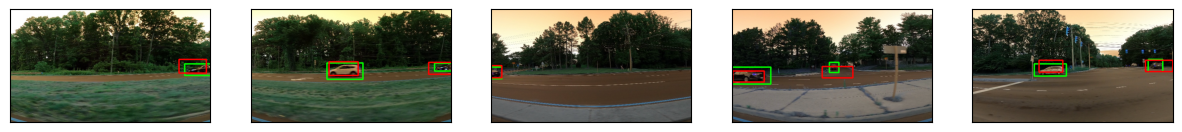

500/500 [==============================] - 128s 257ms/step - loss: 637.9020 - accuracy: 0.9507
Epoch 11/15
1/1 [==============================] - 0s 95ms/step


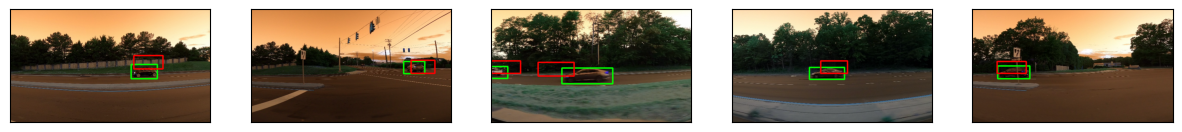

500/500 [==============================] - 132s 264ms/step - loss: 1754.6110 - accuracy: 0.9041
Epoch 12/15
1/1 [==============================] - 0s 50ms/step


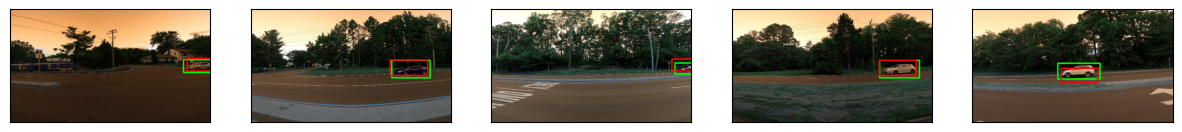

500/500 [==============================] - 135s 270ms/step - loss: 1301.0927 - accuracy: 0.9226
Epoch 13/15
1/1 [==============================] - 0s 31ms/step


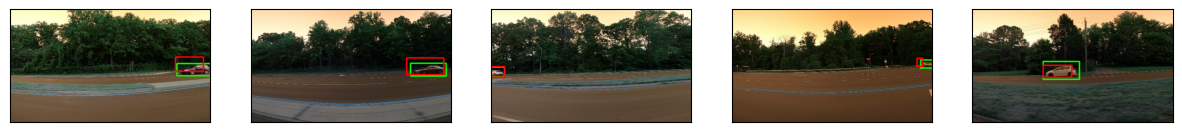

500/500 [==============================] - 131s 262ms/step - loss: 702.8577 - accuracy: 0.9429
Epoch 14/15
1/1 [==============================] - 0s 31ms/step


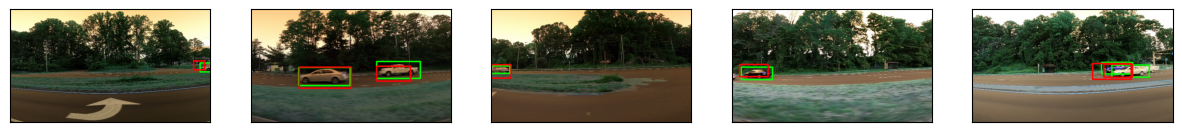

500/500 [==============================] - 133s 266ms/step - loss: 592.8787 - accuracy: 0.9525
Epoch 15/15
1/1 [==============================] - 0s 37ms/step


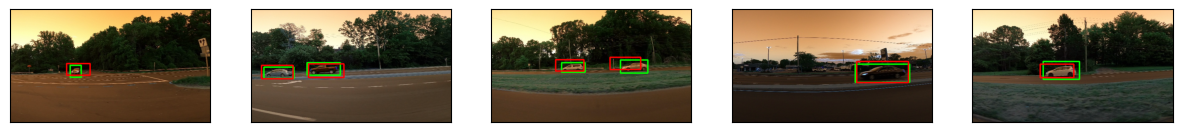

500/500 [==============================] - 137s 274ms/step - loss: 700.2072 - accuracy: 0.9509


In [ ]:
# train the model
with tf.device('/GPU:0'):
    history= model.fit(data_generator(), epochs=15, steps_per_epoch=500, callbacks=[ShowTestImages()])

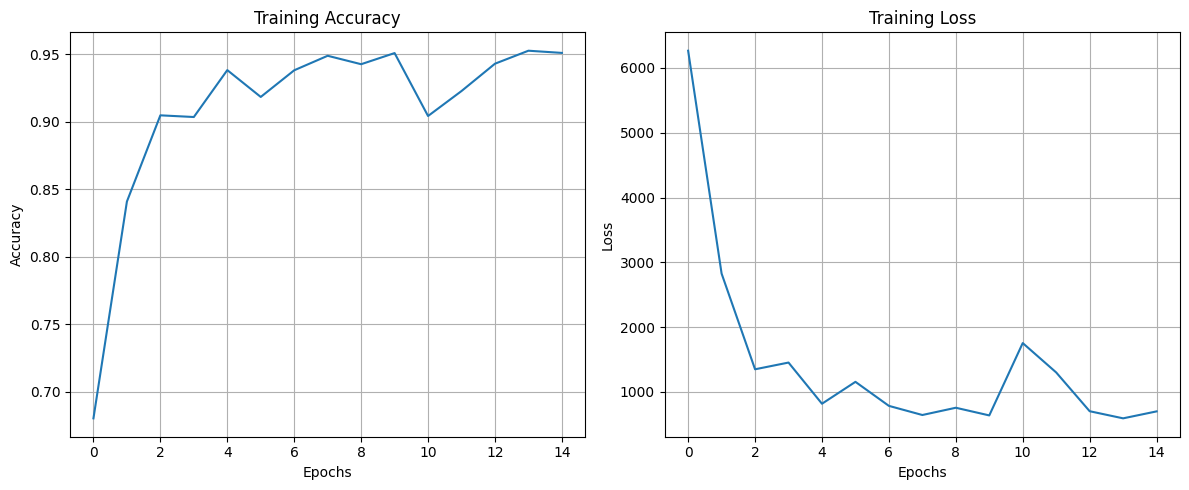

In [ ]:
#history = model.fit(data_generator(), epochs=15, steps_per_epoch=500, callbacks=[ShowTestImages()])

# Plotting accuracy and loss
plt.figure(figsize=(12, 5))

# Accuracy plot
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'])
plt.title('Training Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.grid(True)

# Loss plot
plt.subplot(1, 2, 2)
plt.plot(history.history['loss'])
plt.title('Training Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.grid(True)

plt.tight_layout()
plt.show()


In [ ]:
'''
# Assuming you have a validation dataset and a batch size for validation
validation_data_size = len(validation_data)  # Replace with the size of your validation dataset
batch_size = 16  # Replace with your batch size for validation

# Calculate the number of steps for validation
validation_steps = validation_data_size // batch_size
if validation_data_size % batch_size != 0:
    validation_steps += 1  # Consider the remaining data in an additional step
'''
# Now, you can use this validation_steps variable in your model evaluation
evaluation = model.evaluate(data_generator(), steps=500)  # Replace 'validation_steps' with the appropriate value

print(f"Evaluation - Loss: {evaluation[0]}, Accuracy: {evaluation[1]}")


500/500 [==============================] - 114s 227ms/step - loss: 622.5989 - accuracy: 0.9551
Evaluation - Loss: 622.5989379882812, Accuracy: 0.9551249742507935


# Results

In [ ]:
model.save('car-object-detection.h5')

# Conclusion
I